In [ ]:
from IPython.display import display, Image
path = "C:/Users/Aparna K/Downloads/protocol.png"
display(Image(filename=path, width=600, height=100))
display("<style>.output_png{text-align:center;}</style>")

In [70]:
import pandas as pd
import numpy as np
import time
import csv
import math
import os
import matplotlib as mpl
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from matplotlib.animation import writers

%matplotlib notebook

In [71]:
def normalize(x):
    
    #normalizes the input array by dividing each element by the maximum absolute value in the array
    
    max_val = np.max(np.abs(x))
    return x / max_val

In [72]:
def spectrum(Vib_Freq, observable, fwhm, num_points, spectro):
    
    #builds the x-axis (based on a certain stepsize dependent on the max and min frequency in Vib_Freq array)
    #calculates the y-axis of the spectrum 
    #uses Gaussian and Lorentzian function as the line shape for fitting VCD and ROA peaks respectively
    
    max_freq = 0.49593677
    min_freq = 0
    delta = float((max_freq-min_freq)/num_points)
    Vib_Freq_axis = np.arange(min_freq, max_freq, delta)
    Vib_Freq_axis_cm1 = Vib_Freq_axis*8065.54429
    spec = np.zeros_like(Vib_Freq_axis)
    if spectro == 'ROA':
        peak_pos = peak_finder(observable, Vib_Freq)
        for j in range(len(peak_pos)):
            spec += observable[j]/(1+(2*(Vib_Freq_axis-peak_pos[j])/fwhm)**2)
    else:
        for j in range(len(Vib_Freq)):
            spec += (1/((2.296*10**(-39))*np.sqrt(np.pi)*fwhm))*Vib_Freq[j]*observable[j]*np.exp(-((Vib_Freq_axis-Vib_Freq[j])/fwhm)**2)
    return normalize(spec), Vib_Freq_axis_cm1


In [73]:
def peak_finder(CID3, Vib_Freq):
    
    #find the peaks in a given array and appends the Vib_Freq corresponding to that peak to peak_pos list
    
    peak_pos = []
    peaks, _ = find_peaks(CID3)
    for i in range(len(peaks)):
        temp = peaks[i]
        peak_pos.append(Vib_Freq[temp])
    return np.array(peak_pos)

In [74]:
#params
num_points = 2000
fwhm = 0.008
spectro = input("Enter the spectroscopy method used : ")

Enter the spectroscopy method used : ROA


In [75]:
t1 = time.time()

#reads the file Sorted.txt and stores into a pandas dataframe. Vib_Freq and observable arrays are then extracted from combined dataframe
df = pd.read_csv("Sorted.txt", header=None, delimiter='\t')
combined = df[[2,3]].to_numpy()
Vib_Freq = combined[:,0]
observable = combined[:,1]

#reads the file Combined_Free_Energy.txt and stores into a pandas dataframe. GFE and conformer arrays are then extracted from the combined dataframe
df = pd.read_csv("Combined_Free_Energy.txt", header=None, delimiter='\t')
combined = df[[0,1]].to_numpy()
cmpd2 = combined[:,0]

#call the spectrum function to calculate the spectrum and build the Vib_Freq axis
ROA, Vib_Freq_conv = spectrum(Vib_Freq, observable, fwhm, num_points, spectro)

t2 = time.time()
print(t2-t1)

1.1114819049835205


In [76]:
#snapshot averaged spectrum
t1 = time.time()

X = []
Y = []

snaps = []
overlap_list = []
error_list = []

tot_snapshots = len(cmpd2)
step_size = 50

for snap in range(step_size, tot_snapshots+1, step_size):
    print("Collecting data for snapshots till : ", snap)
    snaps.append(snap)
    
    # read in the file as a DataFrame
    df = pd.read_csv('Sorted.txt', header=None, delimiter='\t')

    # get the rows with conformer_number up to a certain value
    df[0] = df[0].astype(int)
    df = df.loc[df[0] <= snap]

    # extract the Vib_Freq and observable columns as a numpy array
    vib_freq_obs = df[[2, 3]].to_numpy()
    Vib_Freq3 = vib_freq_obs[:,0]
    observable3 = vib_freq_obs[:,1]
    observable3 = observable3/snap
    
    #calculate the spectrum and build the Vib_freq axis for the observable and Vib_Freq values upto a certain number of conformers
    spec,freq = spectrum(Vib_Freq3, observable3, fwhm, num_points, spectro)
    X.append(freq)
    Y.append(spec)
    
    #calculate the error spectrum and append it to a list
    error = ROA - spec
    error_list.append(error)
    
    # Calculate the normlaized overlap and append it to list
    overlap = np.trapz(np.array(ROA)*np.array(spec), Vib_Freq_conv)
    deno1 = np.trapz(np.array(ROA)*np.array(ROA), Vib_Freq_conv)
    deno2 = np.trapz(np.array(spec)*np.array(spec), Vib_Freq_conv)
    deno = np.sqrt(deno1*deno2)
    overlap /= deno
    overlap_list.append(overlap)
    
t2 = time.time()
print(t2-t1)

12.375020503997803


<IPython.core.display.Javascript object>


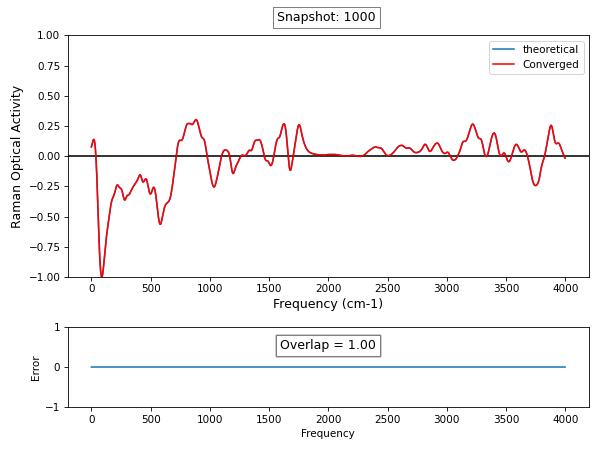

In [78]:
# Create the figure and axes
plt.rcParams["figure.figsize"] = [8,6]
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})

#initialize the spectrum
line1, = ax1.plot(X[0], Y[0], label="theoretical")

#get the converged spectrum data
freq_exp = np.array(Vib_Freq_conv)
spec_exp = np.array(ROA)

#initialize the error plot
line2, = ax2.plot(X[0], Y[0], label="Error")

#ax1.set_xlim(210,2500)
#ax2.set_xlim(210,2500)

ax1.set_ylim(-1,1)
ax2.set_ylim(-1,1)

#set the axes
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Error')
ax1.set_xlabel('Frequency (cm-1)', fontsize=12)
if spectro == 'ROA':
    ax1.set_ylabel('Raman Optical Activity', fontsize=12)
else:
    ax1.set_ylabel('Vibrational Circular Dichroism', fontsize=12)
    
ax1.axhline(y = 0, color = 'black')
snapshot = ax1.text(2400, 1.2, '', ha='right', va='top', fontsize=12,bbox=dict(facecolor='white', edgecolor='gray'))

# Define the number of frames to be the length of Y
num_frames = len(Y)

#plot the converged spectrum
ax1.plot(Vib_Freq_conv, ROA, color="red", label="Converged")
ax1.legend()

# Define the animation function to update the y-data of line1 and snapshot
def animate(i):
    
    # Plot the ROA/VCD spectrum on the upper axes
    line1.set_ydata(Y[i])
    line1.set_xdata(X[i])
    
    # Plot the snapshot number as a text box
    snapshot.set_text(f'Snapshot: {snaps[i]}')
    
    # Plot the error spectrum on the lower axes
    line2.set_ydata(error_list[i])
    line2.set_xdata(X[i])
    
    # Plot the overlap as a text box
    ax2.text(2400, 0.7, 'Overlap = %.2f' % overlap_list[i], ha='right', va='top', fontsize=12, bbox=dict(facecolor='white', edgecolor='gray'))
    area = np.trapz(error_list[i], x=freq_exp)

    return line1,line2,snapshot
    

# Plotting dynamic spectrum
ani = anim.FuncAnimation(
    fig, animate, frames=num_frames, interval=1000,repeat=False)

plt.show()

<IPython.core.display.Javascript object>


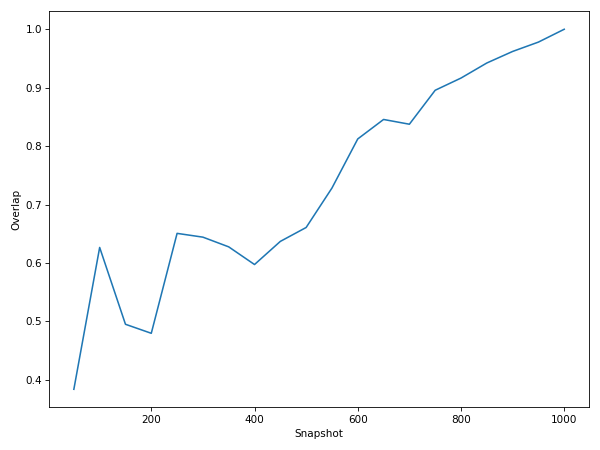

In [79]:
# Plot the convergence of teh spectrum with snapshot number
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = [10,8]
plt.rcParams["figure.autolayout"] = True

plt.plot(snaps, overlap_list)

plt.xlabel("Snapshot")
plt.ylabel("Overlap")

plt.show()

<IPython.core.display.Javascript object>


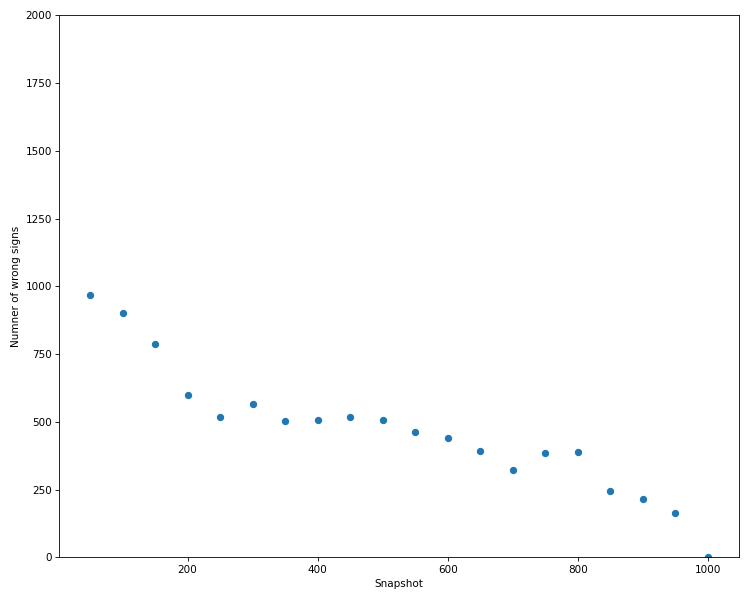

In [80]:
# Calculate the number of wrong signs of each of the snapshot avergaed spectra with respect to the converged spectrum
# This gives a qualitative similarity of the spectra

num_wrong_sign = []
for i in range(len(Y)):
    num_wrong_sign.append(np.sum(np.multiply(ROA, Y[i]) < 0))
    
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = [10,8]
plt.rcParams["figure.autolayout"] = True

#plt.plot(snaps, num_wrong_sign)
ax.scatter(snaps, num_wrong_sign)
ax.set_ylim(0,2000)

plt.xlabel("Snapshot")
plt.ylabel("Numner of wrong signs")

plt.show()